# User input

# Data Representation classes

In [67]:
import enum
from enum import Enum
import numpy as np

class User():
    """
    The user object should be initialized with the activity to simulate during a full week.
    """
    def __init__(self):
        self.name = ''
        self.activity = np.array(50)
        self.pod = None

class UserPod():
    def __init__(self, user):
        self.user = user
        self.node = None
        self.start_time = 0
  
     
    @property
    def is_pending(self):
        return self.node == None
    
    @property
    def is_assigned(self):
        return self.node != None
    
    
    def delete(self):
        self.user.pod = None
        self.node = None
        self.start_time = 0
        
    
        
class NodeState(enum.Enum):
    Stopped = 0
    Starting = 1
    Running = 2
    Stopping = 3
    
class Node():
    
    def __init__(self, capacity=20):
        self.capacity = capacity
        self.started_state = np.array([NodeState.Stopped for i in range(50)])
        self.utilized_capacity = np.zeros(50)
        self.list_pods = []
        
           
    def remove_pod_ref(self,pod,time):
        self.list_pods.remove(pod)
        if self.utilized_capacity[time-1] > 0:
            self.utilized_capacity[time:] = self.utilized_capacity[time-1] - 1
        #else:
            #raise "this should never happen"
            

# Simulation initialization

### User Initialization

In [68]:

user_pool = []
user1 = User()
user1.activity = [0,0,0,0,0,1,1,1,1,1,
                  1,0,0,0,1,0,1,0,0,1,
                  1,1,1,1,1,0,0,1,0,0,
                  0,0,0,0,0,0,0,0,0,0,
                  1,1,1,1,1,1,1,1,0,0]
user1.name = 'First'
user_pool.append(user1)

user2 = User()
user2.activity = [0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0]
user2.name = 'Second'
user_pool.append(user2)
user3 = User()
user3.activity = [0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1]
user3.name = 'third'
user_pool.append(user3)
user4 = User()
user4.activity = [0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0]
user4.name = 'fourth'
user_pool.append(user4)
user5 = User()
user5.activity = [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0]
user5.name = 'fifth'
user_pool.append(user5)


### Node Initialization

In [69]:
node_pool = []
node_pool.append(Node(capacity = 3))
node_pool.append(Node(capacity = 3))

# Simulation loop

In [70]:
for t in range(50):
    # Create user pods for active users without a pod
    for user in user_pool:
        if user.activity[t] == 1 and user.pod == None:
            user.pod = UserPod(user)
            
            
    """
    Scheduler is responsible of placement of pending pods
    on the most resource utilized node that still has room.
    """
    
    ## Identify pods to schedule
    pending_pods = [user.pod for user in user_pool if user.pod != None and user.pod.is_pending]  
    sorted_node_pool = sorted(node_pool, key=lambda node:node.utilized_capacity[t] ,reverse = True) 
    for pod in pending_pods:
        
        ## Find a node to schedule the pod on
        for node in sorted_node_pool:
            if node.utilized_capacity[t] < node.capacity:
                pod.node = node
                pod.start_time = t
                node.list_pods.append(pod)
                node.utilized_capacity[t:] = node.utilized_capacity[t-1] + 1
                break
    
    
    """
    Cluster Autoscaler (CA): start nodes
    The CA looks for 'Stopped' nodes which have some pods assigned to them,
    and transitions the state of those nodes from 'Stopped' to 'Running'
    """
    nodes_to_start = [node for node in node_pool if node.started_state[t] == NodeState.Stopped and len(node.list_pods) > 0]
    for node in nodes_to_start:
        node.started_state[t:t+5] = NodeState.Starting
        node.started_state[t+5:] = NodeState.Running

    
    """
    Cluster Autoscaler (CA): stop nodes
    If a node doesn't have any pods scheduled to it for 10 minutes, the CA makes the node 'Stopped'.
    """
    if t >= 10:
        started_nodes = [node for node in node_pool if node.started_state[t] == NodeState.Running]
        no_of_started_nodes = len(started_nodes) # count of started nodes
        for node in started_nodes:
            #if no_of_started_nodes > max_min_nodes.lower:
            # Min no of nodes has been taken as 1.
            if no_of_started_nodes > 1:
                if  np.sum(node.utilized_capacity[t-10:t+1]) == 0:
                    node.started_state[t] = NodeState.Stopping  
                    node.started_state[t+1:] = NodeState.Stopped
                    no_of_started_nodes -= 1
            else:
                break
    
    
    ## The amount of time a user is allowed to be inactive before the user's pod is culled
    pod_culling_max_inactivity_time = 10
    ## The amount of time a pod is allowed to live before it is culled
    pod_culling_max_lifetime = 20 
    
    for node in node_pool:
        pods_assigned_to_node = [pod for pod in node.list_pods]
        for pod in pods_assigned_to_node:
            
            """
            Pod Culler: cull for inactivity
            
            The Pod Culler deletes the user pods of users who have been inactive 
            for a too long interval of time (pod_culling_max_inactivity_time)
            """
            
            if pod_culling_max_inactivity_time > 0:
                if t >= pod_culling_max_inactivity_time and np.sum(pod.user.activity[t-pod_culling_max_inactivity_time:t+1]) == 0:
                    pod.delete()
                    node.remove_pod_ref(pod, t)
                    continue
                    
            """
            Pod Culler: cull for max lifetime
            
            The Pod Culler deletes the user pods that has been running for too long (pod_culling_max_lifetime)
            If pod_culling_max_lifetime is 0 then the user pod has infinite lifetime.
            """
            
            if pod_culling_max_lifetime > 0:
                if t - pod.start_time >= pod_culling_max_lifetime:
                    assert t - pod.start_time == pod_culling_max_lifetime
                    pod.delete()
                    node.remove_pod_ref(pod, t)
                    
    

# Simulation analysis

TODO: Plot the node.utilized_capacity, this will show you how nodes are added or not etc.
TODO: Reduce the time simulated to something more manageable and easy to plot (or not)

In [71]:
# storing the min by min utilization data
time_data = list(range(50)) 

node_data = {'time':time_data}

for index,node in enumerate(node_pool):
    node_data_utilized_capacity = []
    node_data_utilized_percent = []

    for i in range(50):
        node_data_utilized_capacity.append(node.utilized_capacity[i])
        node_data_utilized_percent.append((node.utilized_capacity[i] / node.capacity)*100)
    
    node_data['node'+ str(index)+ '_utilized_capacity'] = node_data_utilized_capacity
    node_data['node'+ str(index)+ '_utilized_percent'] = node_data_utilized_percent
    
    utilization_data = pd.DataFrame(data = node_data)


In [75]:
utilization_data

,time,node0_utilized_capacity,node0_utilized_percent,node1_utilized_capacity,node1_utilized_percent
0,0,0.0,0.000000,0.0,0.000000
1,1,0.0,0.000000,0.0,0.000000
2,2,0.0,0.000000,0.0,0.000000
3,3,0.0,0.000000,0.0,0.000000
4,4,1.0,33.333333,0.0,0.000000
5,5,2.0,66.666667,0.0,0.000000
6,6,2.0,66.666667,0.0,0.000000
7,7,2.0,66.666667,0.0,0.000000
8,8,3.0,100.000000,0.0,0.000000
9,9,3.0,100.000000,1.0,33.333333


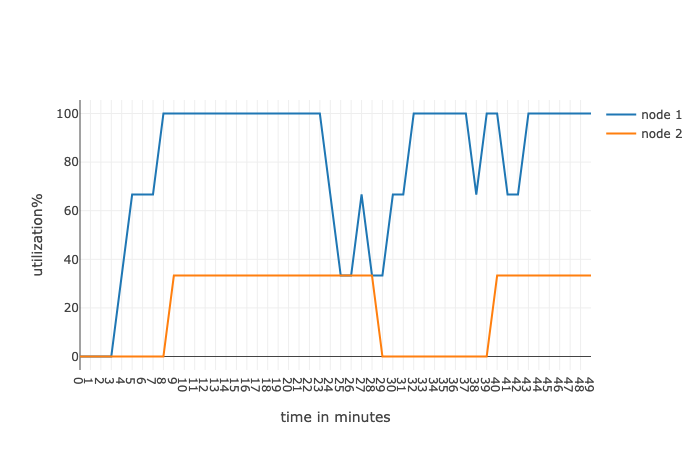

In [74]:
#Plotting the graph for the node wise utilization
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode , plot, iplot
trace1 = go.Scatter(
                        x = utilization_data['time'],
                        y = utilization_data['node0_utilized_percent'],
                        mode = 'lines',
                        name = 'node 1'
                        )
trace2 = go.Scatter(
                        x = utilization_data['time'],
                        y = utilization_data['node1_utilized_percent'],
                        mode = 'lines',
                        name = 'node 2'
      )
    

data = [trace1,trace2]
layout = go.Layout(
        xaxis=dict(
          title='time in minutes',
          tickmode='linear',
          tick0=0,
          dtick=1
                  ),
        yaxis=dict(
          title='utilization%'
                  )  
               )
fig = go.Figure(data=data, layout=layout)
iplot(fig)


TODO: lets have a line chart like this one:
https://grafana.mybinder.org/d/3SpLQinmk/1-overview?refresh=1m&panelId=26&fullscreen&orgId=1